# Team Apple - Project - Data Mining and Machine Learning
# EDA and Preprocessing
This notebook focuses on EDA, Data Vizualisation and preprocessing of the data.

## 🧭 Project description 
Real or Not? NLP with Disaster Tweets: In this project you are challenged to build a Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.

## 👥 Team members
- Stéphane Vez
- Maël Maceiras
- Pierre Huber



## 📚 Libraries

First of all, we will import all the packages that we thought that we might use in order to get the best model. Please run the cells below⤵️

In [1]:
!python -m pip install --upgrade pip

In [2]:
!python -m pip install spacy

In [3]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 69.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/venv/lib/python3.7/site-packages/en_core_web_sm -->
/opt/venv/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [4]:
!python -m pip install nltk

In [5]:
import nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Import requiered packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import spacy
import string
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re
from nltk.corpus import stopwords
import numpy as np
from collections import defaultdict
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

## 📂 Data

Secondly, we have to import the data that were prodived for this specific project. Each dataset is stored in the repositery "data" of our project DMML_Apple.

In [7]:
sample = pd.read_csv('https://raw.githubusercontent.com/PierreHuber/DMML_Apple/main/data/sample_submission.csv')
test = pd.read_csv("https://raw.githubusercontent.com/PierreHuber/DMML_Apple/main/data/test_data.csv")
test = test.set_index(test.id).drop(columns=['id'])
training = pd.read_csv('https://raw.githubusercontent.com/PierreHuber/DMML_Apple/main/data/training_data.csv')
training = training.set_index(training.id).drop(columns=['id'])

## 🔦 EDA and 📊 Data Visualization

This part of our notebook is dedicated to Exploratory Data Analysis (EDA) as well as the Data Visualization. <h5> This part will help us to grasp the complexity of the dataset for this project.

### Sample of the dataframe

In [8]:
training.head(5)

,keyword,location,text,target
id,,,,
3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


### Description of the different features

In [9]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6471 entries, 3738 to 1779
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   6416 non-null   object
 1   location  4330 non-null   object
 2   text      6471 non-null   object
 3   target    6471 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 252.8+ KB


### Dataframe cardinality's

In [10]:
training.shape

(6471, 4)

|                | Value |
|----------------|-------|
| Dimensionality | 6471  |
| Numerosity     | 4     |

### Columns Name

In [11]:
training.columns

Index(['keyword', 'location', 'text', 'target'], dtype='object')

### Columns Type

In [12]:
training.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

At first sight, we will not need to chagne the data types

### Check for null values

In [13]:
training.isnull().sum()

keyword       55
location    2141
text           0
target         0
dtype: int64

### The different key words

In [14]:
training["keyword"].nunique()

221

In [15]:
training["keyword"].value_counts()

deluge                   39
earthquake               38
collision                37
harm                     37
sinking                  36
                         ..
forest%20fire            18
epicentre                10
threat                   10
radiation%20emergency     9
inundation                6
Name: keyword, Length: 221, dtype: int64

There are 221 different keywords.

### Base Rate

In [16]:
round(training.target.value_counts()[0] / len(training), 3)


0.572

The base rate of our problem is 0.572.

### Target values

In [17]:
training["target"].value_counts()

0    3701
1    2770
Name: target, dtype: int64

1 = this tweet is NOT about a real disaster

0 = this tweet is about a real disaster

([<matplotlib.axis.XTick at 0x7fbef7eaba50>,
 [Text(0, 0, 'Real disaster'), Text(1, 0, 'Not a disaster')])

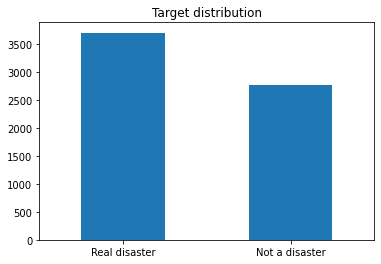

In [18]:
labels = ['Real disaster', 'Not a disaster']
training["target"].value_counts()[:2].plot(kind='bar', title="Target distribution")
plt.xticks([0,1], labels, rotation ='horizontal') 

### Stopwords

In [19]:
stops =  set(stopwords.words('english'))

<BarContainer object of 15 artists>

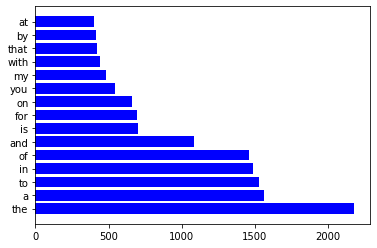

In [20]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

#print('Number of stopwords: %d' % len(spacy_stopwords))

#print('20 stopwords: %s' % list(spacy_stopwords)[:20])

def list_stopwords_for_target():
  list_target = []
  for text_row in training['text'].str.split():
    for k in text_row:
      list_target.append(k)
  return list_target

list_stopwords=list_stopwords_for_target()

dic=defaultdict(int)
for word_1 in list_stopwords:
    if word_1 in spacy_stopwords:
        dic[word_1]+=1
        
dictionary_15_first=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:15]
x,y=zip(*dictionary_15_first)
plt.barh(x,y, color='blue')

### Punctuation 

<BarContainer object of 15 artists>

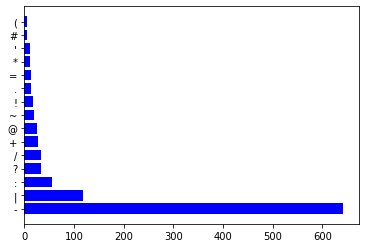

In [21]:
punctuations=string.punctuation

def list_punctuations_for_target():
  list_punctuations = []
  for text_row in training['text'].str.split():
    for k in text_row:
      list_punctuations.append(k)
  return list_punctuations

list_punctuation_p=list_punctuations_for_target()

dic_2=defaultdict(int)
for punc in list_punctuation_p:
    if punc in punctuations:
        dic_2[punc]+=1
        
dictionary_15_first_punct=sorted(dic_2.items(), key=lambda x:x[1], reverse=True)[:15]
x,y=zip(*dictionary_15_first_punct)
plt.barh(x,y, color='blue')

### Common words

<BarContainer object of 20 artists>

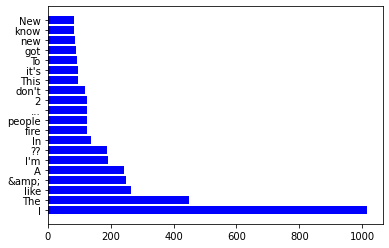

In [22]:
def list_all_words():
  the_list = []
  for text_row in training['text'].str.split():
    for k in text_row:
      the_list.append(k)
  return the_list

list_of_all_words=list_all_words()

dic_3=defaultdict(int)
for word_3 in list_of_all_words:
    if word_3 not in spacy_stopwords and word_3 not in punctuations:
        dic_3[word_3]+=1

dictionary_20_first_word=sorted(dic_3.items(), key=lambda x:x[1], reverse=True)[:20]
x,y=zip(*dictionary_20_first_word)
plt.barh(x,y, color='blue', )

In [23]:
print(dictionary_20_first_word)

[('I', 1014), ('The', 450), ('like', 264), ('&amp;', 250), ('A', 242), ("I'm", 191), ('??', 188), ('In', 137), ('fire', 126), ('people', 126), ('...', 124), ('2', 124), ("don't", 117), ('This', 95), ("it's", 95), ('To', 93), ('got', 89), ('new', 87), ('know', 83), ('New', 82)]


In [24]:
training.isnull().sum()

keyword       55
location    2141
text           0
target         0
dtype: int64

# Tokenizer

In [27]:
def spacy_tokenizer(sentence):
    mytokens = sp(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

In [ ]:
sp = spacy.load('en')
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [29]:

#text tokenizer: stopwords, punctuation, lowercase, lemmatize
tweets_token=[] #list of tokens for one row
for tweet in tqdm(training.text):
    tweets_token.append(spacy_tokenizer(tweet))
tokenSerie=[] #list of tweets_token
for i in range(0, len(tweets_token)):
    tokens=""
    for j in tweets_token[i]:
        tokens+=j
        tokens+=" "
    tokenSerie.append(tokens)
training['tokens']=tokenSerie #append column 'tokens'
training.tokens.to_csv(r'tokens.csv', index = False) #store tokens in csv

100%|██████████| 6471/6471 [00:55<00:00, 116.09it/s]


In [30]:
#new column 'list_tokens' where tokens are in list form not in text form like 'tokens'
list_tokens=[]
for each in training.tokens.values:
    list_token=str(each).split()
    list_tokens.append(list_token)
training['list_tokens']=list_tokens

In [31]:
#remove @twitter_user, numbers and http link from list_tokens
list_each=[]
for each in training.list_tokens.values:
    for element in each:
        if element[0]=='@' or 'http://' in element or 'https://' in element or element.isdigit() == True:
            each.remove(element)
    list_each.append(each)
tokenSerie=[] #
for i in range(0, len(list_each)):
    tokens=""
    for j in list_each[i]:
        tokens+=j
        tokens+=" "
    tokenSerie.append(tokens)
training['tokens2']=tokenSerie #append column 'tokens'
training.tokens2.to_csv(r'tokens2.csv', index = False) #store list_tokens in csv

In [32]:
training['merged'] = training['keyword'] + ' ' + training['tokens']
training['merged'].fillna(' ', inplace=True)
training['merged2'] = training['keyword'] + ' ' + training['tokens2']
training['merged2'].fillna(' ', inplace=True)

In [33]:
training.to_csv(r'training.csv', index=False)

In [34]:
training

,keyword,location,text,target,tokens,list_tokens,tokens2,merged,merged2
id,,,,,,,,,
3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,black eye 9 space battle occur star o784 invol...,"[black, eye, space, battle, occur, star, o784,...",black eye space battle occur star o784 involve...,destroyed black eye 9 space battle occur star ...,destroyed black eye space battle occur star o7...
853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0,world fedex longer transport bioterror germ wa...,"[world, fedex, longer, transport, bioterror, g...",world fedex longer transport bioterror germ wa...,bioterror world fedex longer transport bioterr...,bioterror world fedex longer transport bioterr...
10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1,reality training train fall elevated track win...,"[reality, training, train, fall, elevated, tra...",reality training train fall elevated track win...,windstorm reality training train fall elevated...,windstorm reality training train fall elevated...
5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1,taiwan grace expect large rock tree mud unstab...,"[taiwan, grace, expect, large, rock, tree, mud...",taiwan grace expect large rock tree mud unstab...,hazardous taiwan grace expect large rock tree ...,hazardous taiwan grace expect large rock tree ...
6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1,new isis video isis threaten behead croatian h...,"[new, isis, video, isis, threaten, behead, cro...",new isis video isis threaten behead croatian h...,hostage new isis video isis threaten behead cr...,hostage new isis video isis threaten behead cr...
...,...,...,...,...,...,...,...,...,...
4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1,earthquake sismo m 1.9 15 km e anchorage alask...,"[earthquake, sismo, m, 1.9, km, e, anchorage, ...",earthquake sismo m 1.9 km e anchorage alaska t...,earthquake earthquake sismo m 1.9 15 km e anch...,earthquake earthquake sismo m 1.9 km e anchora...
3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0,@emiiliexirwin totally agree 23 know birth con...,"[totally, agree, know, birth, control, true, w...",totally agree know birth control true want der...,derail @emiiliexirwin totally agree 23 know bi...,derail totally agree know birth control true w...
9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1,hollywood movie trapped miners release chile 3...,"[hollywood, movie, trapped, miners, release, c...",hollywood movie trapped miners release chile h...,trapped hollywood movie trapped miners release...,trapped hollywood movie trapped miners release...


In [43]:
training.drop(columns=['location','text','list_tokens']).sample(n=5)

,keyword,target,tokens,tokens2,merged,merged2
id,,,,,,
7885,quarantined,0,hey @reddit concept quarantine sense people qu...,hey concept quarantine sense people quarantine...,quarantined hey @reddit concept quarantine sen...,quarantined hey concept quarantine sense peopl...
5072,famine,0,@robertmeyer9 example low food price cause far...,example low food price cause farmer broke= fam...,famine @robertmeyer9 example low food price ca...,famine example low food price cause farmer bro...
7976,razed,1,late home raze northern california wildfire ht...,late home raze northern california wildfire ht...,razed late home raze northern california wildf...,razed late home raze northern california wildf...
2873,damage,1,@bradleybrad47 yeah fast extremely high damage...,yeah fast extremely high damage want fast u the-,damage @bradleybrad47 yeah fast extremely high...,damage yeah fast extremely high damage want fa...
4849,evacuation,1,ibrahimmisau faan order evacuation abandon air...,ibrahimmisau faan order evacuation abandon air...,evacuation ibrahimmisau faan order evacuation ...,evacuation ibrahimmisau faan order evacuation ...


In [42]:
training_print.sample(n=5)

,keyword,target,tokens,tokens2,merged,merged2
id,,,,,,
2755,curfew,1,ara news report jan fighter infiltrate ashrafi...,ara news report jan fighter infiltrate ashrafi...,curfew ara news report jan fighter infiltrate ...,curfew ara news report jan fighter infiltrate ...
1341,blown%20up,1,white family supposedly represent america grea...,white family supposedly represent america grea...,blown%20up white family supposedly represent a...,blown%20up white family supposedly represent a...
6335,hostages,1,2 hostage libya remain unharmed government sou...,hostage libya remain unharmed government sourc...,hostages 2 hostage libya remain unharmed gover...,hostages hostage libya remain unharmed governm...
363,annihilation,0,soul punish withåêannihilation http://t.co/c1q...,soul punish withåêannihilation http://t.co/zhp...,annihilation soul punish withåêannihilation ht...,annihilation soul punish withåêannihilation ht...
6518,injuries,0,fucking injury https://t.co/tuzacdwfqd,fucking injury,injuries fucking injury https://t.co/tuzacdwfqd,injuries fucking injury


Above, is the final note book we will use for our experimentation on the Notebook "Apple_Results".